![](https://lh6.googleusercontent.com/-NzN4oVW-b8g/Rmpn3smdoCI/AAAAAAAAAKM/tRi8sd_STco/s1600/)
> www.codeproject.com/KB/recipes/619039/SIFT.JPG

[Cathedral of St. John the Baptist][trnava] in Trnava, Slovakia.

# Feature Extraction
For this competition, we will be mostly matching images based on their local features, a.k.a. interest points.

A local image feature is a tiny patch in the image that's invariant to image scaling, rotation and change in illumination.  It's like the tip of a tower, or the corner of a window in the image above.  Unlike a random point on the background (sky) in the image above, the tip of the tower can be precise detected in most images of the same scene.  It is geometricly (translation, rotation, ...) and photometricly (brightness, exposure, ...) invariant.

A good local feature is like the piece you start with when solving a jigsaw puzzle, except on a much smaller scale.  It's the eye of the cat or the corner of the table, not a piece on a blank wall.


The extracted local features [must be][lectures]:
- *Repeatable* and *precise* so they can be extracted from different images showing the same object.
- *Distinctive* to the image, so images with different structure will not have them.


There could be hundreds or thousands of such features in an image.  An image matcher algorithm could still work if some of the features are blocked by an object or badly deformed due to change in brightness or exposure.  Many local feature algorithms are highly efficient and can be used in real-time applications.

Due to these requirements, most local feature detectors extract corners and blobs.

## Local Feature Detection and Description
There is a wealth of algorithms satisfying the above requirements for feature detection (finding interest points on an image) and description (generating a vector representation for them).  They include [Harris Corner Detection][harris], [Scale Invariant Feature Transform (SIFT)][sift], [Speeded-Up Robust Features (SURF)][surf], [Features from Accelerated Segment Test (FAST)][fast], and [Binary Robust Independent Elementary Features (BRIEF)][brief].

In this tutorial, we will use [Oriented FAST and Rotated BRIEF (ORB)][orb] for feature detection and description.  This algorithm was [developed][orb_paper] and [implemented][orb] by OpenCV Labs, and it's part of their [OpenCV library][opencv_lib] for computer vision.

Let's start by extracting the local features of the image shown in the banner above.  It's the [Cathedral of St. John the Baptist][trnava] in Trnava, Slovakia.

[lectures]: https://pdfs.semanticscholar.org/5255/490925aa1e01ac0b9a55e93ec8c82efc07b7.pdf
[harris]: https://docs.opencv.org/3.3.1/dc/d0d/tutorial_py_features_harris.html
[sift]: https://docs.opencv.org/3.3.1/da/df5/tutorial_py_sift_intro.html
[surf]: https://docs.opencv.org/3.3.1/df/dd2/tutorial_py_surf_intro.html
[fast]: https://docs.opencv.org/3.3.1/df/d0c/tutorial_py_fast.html
[brief]: https://docs.opencv.org/3.3.1/dc/d7d/tutorial_py_brief.html
[orb]: https://docs.opencv.org/3.3.1/d1/d89/tutorial_py_orb.html
[orb_paper]: http://www.willowgarage.com/sites/default/files/orb_final.pdf
[opencv_lib]: https://docs.opencv.org/3.3.1/index.html
[trnava]: https://en.wikipedia.org/wiki/St._John_the_Baptist_Cathedral_(Trnava)
[uwash]: https://courses.cs.washington.edu/courses/cse455/09wi/Lects/lect6.pdf

In [1]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import os

%matplotlib inline

In [2]:
img_original_1 = 'building_1.jpg'
img_original_2 = 'building_2.jpg'

dataset_path = '.'
img_building = cv2.imread(os.path.join(dataset_path, img_original_1))
img_building = cv2.cvtColor(img_building, cv2.COLOR_BGR2RGB)  # Convert from cv's BRG default color order to RGB

The found interest points/features are circled in the image above.  As we can see, some of these points are unique to this scene/building like the points near the top of the two towers.  However, others like the ones at the top of the tree may not be distinctive.

## Feature Matching
Now let's see if we can extract the same features from a different image of the same cathedral taken from a different angle.

In [3]:
def image_detect_and_compute(detector, img_name):
    """Detect and compute interest points and their descriptors."""
    img = cv2.imread(os.path.join(dataset_path, img_name))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    kp, des = detector.detectAndCompute(img, None)
    return img, kp, des

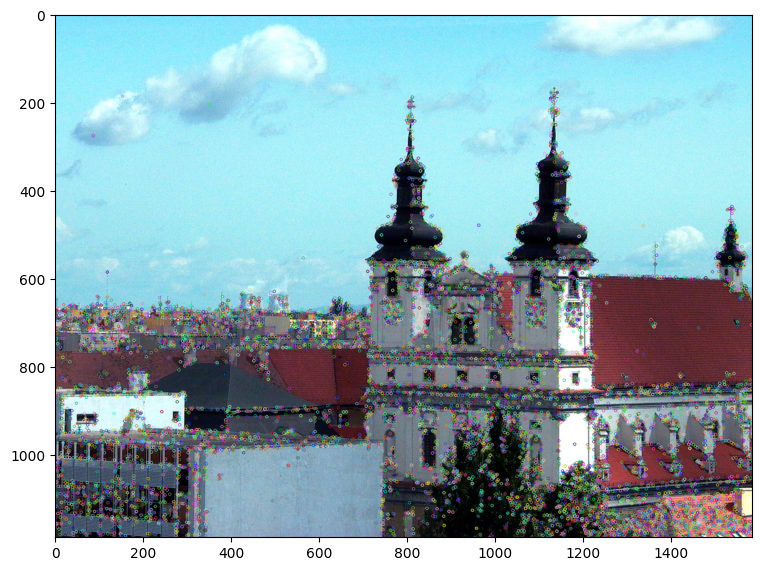

In [4]:
sift = cv2.SIFT_create()
kp, des = sift.detectAndCompute(img_building, None)
img_kp = cv2.drawKeypoints(img_building, kp, img_building)

plt.figure(figsize=(9, 9))
plt.imshow(img_kp); plt.show()

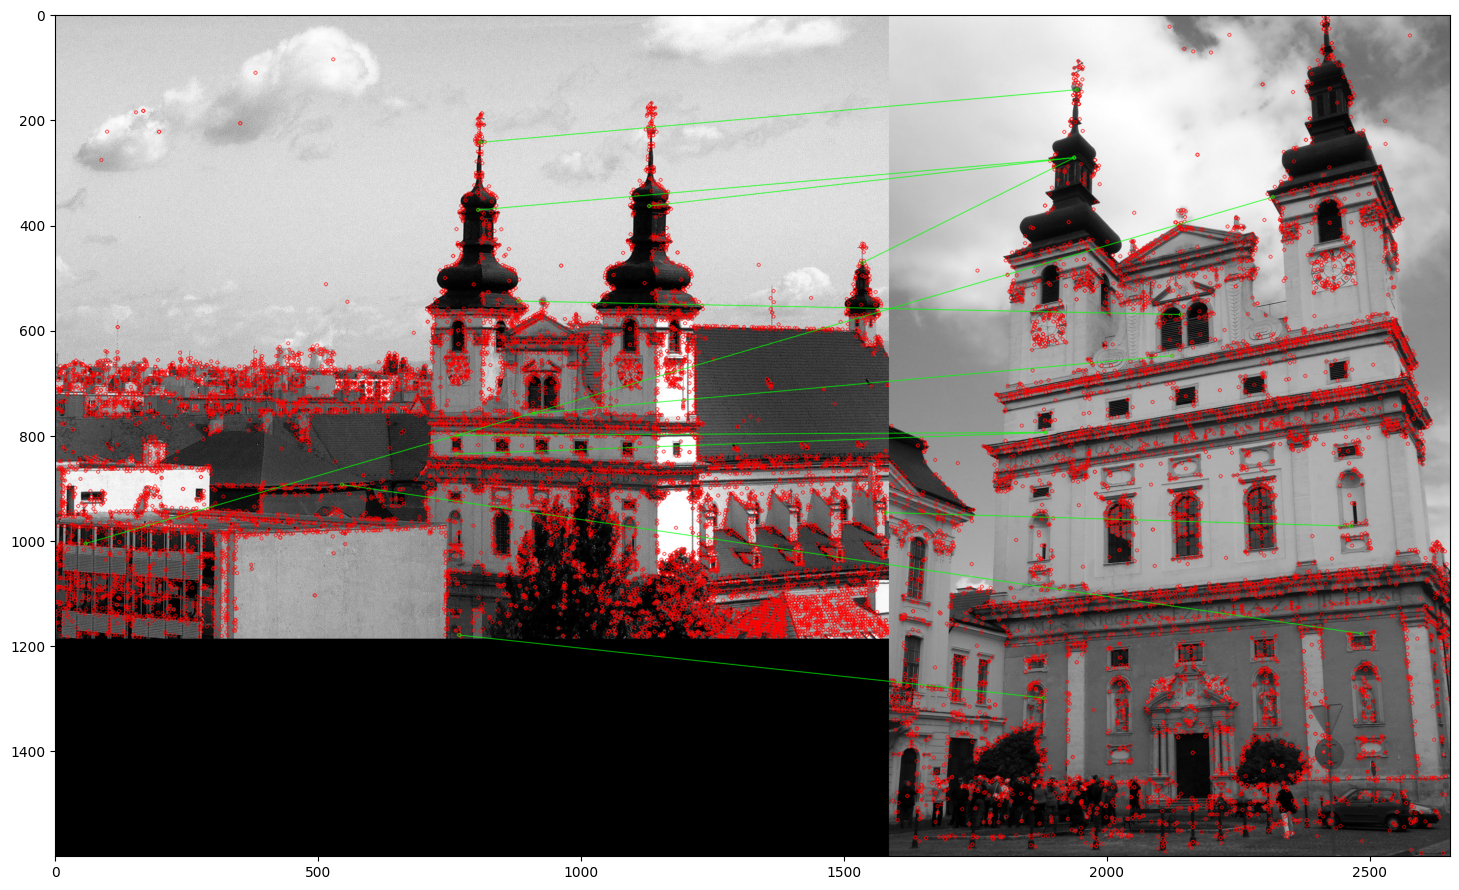

In [5]:
img1, kp1, des1 = image_detect_and_compute(sift, img_original_1)
img2, kp2, des2 = image_detect_and_compute(sift, img_original_2)

FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 8)
search_params = dict(checks=50)

flann = cv2.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1, des2, k=2)

matchesMask = [[0, 0] for i in range(len(matches))]
# ratio test as per Lowe's paper
for i, (m, n) in enumerate(matches):
    if m.distance < 0.55*n.distance:
        matchesMask[i] = [1, 0]

draw_params = dict(matchColor=(0, 255, 0),
                   singlePointColor=(255, 0, 0),
                   matchesMask=matchesMask,
                   flags=0)

img3 = cv2.drawMatchesKnn(img1, kp1, img2, kp2, matches, None, **draw_params)
plt.figure(figsize=(18, 18))
plt.imshow(img3); plt.show()

More than half of the top 10 matches were correct.  In real appliations, instead of using the top `x` matches,  a match distance threshold is used to filter out spurious matches.


## References
- Kristen Grauman and Bastian Leibe. 2011. [Visual Object Recognition (1st ed.)][lectures]. Morgan & Claypool Publishers.
- Rublee, Ethan & Rabaud, Vincent & Konolige, Kurt & Bradski, Gary. (2011). [ORB: an efficient alternative to SIFT or SURF][orb_paper]. Proceedings of the IEEE International Conference on Computer Vision.

[lectures]: https://pdfs.semanticscholar.org/5255/490925aa1e01ac0b9a55e93ec8c82efc07b7.pdf
[orb_paper]: http://www.willowgarage.com/sites/default/files/orb_final.pdf

